True

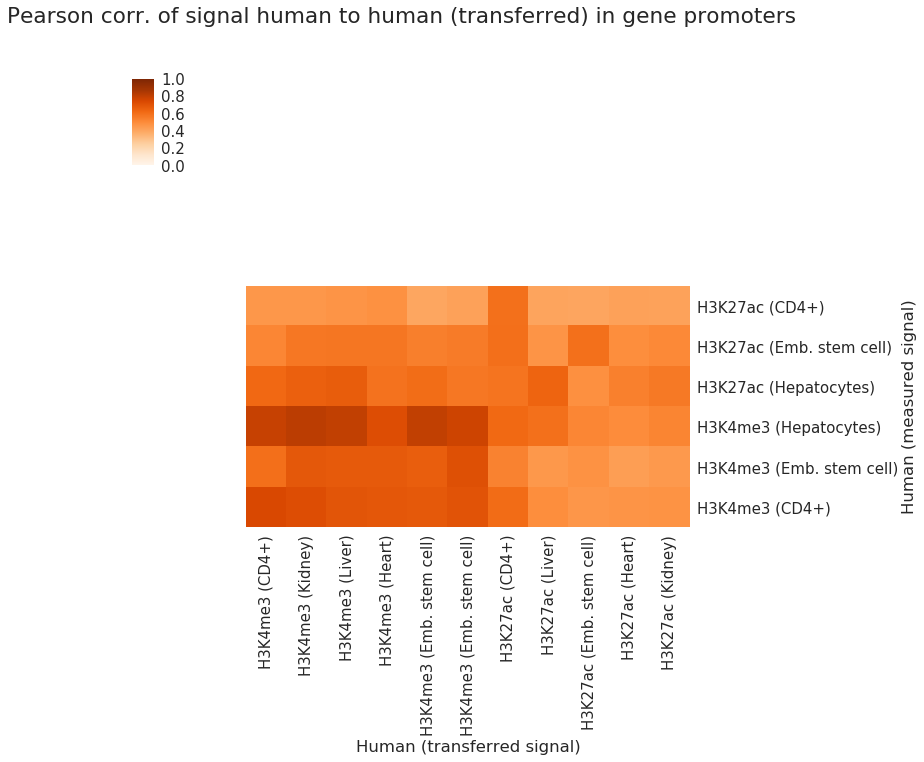

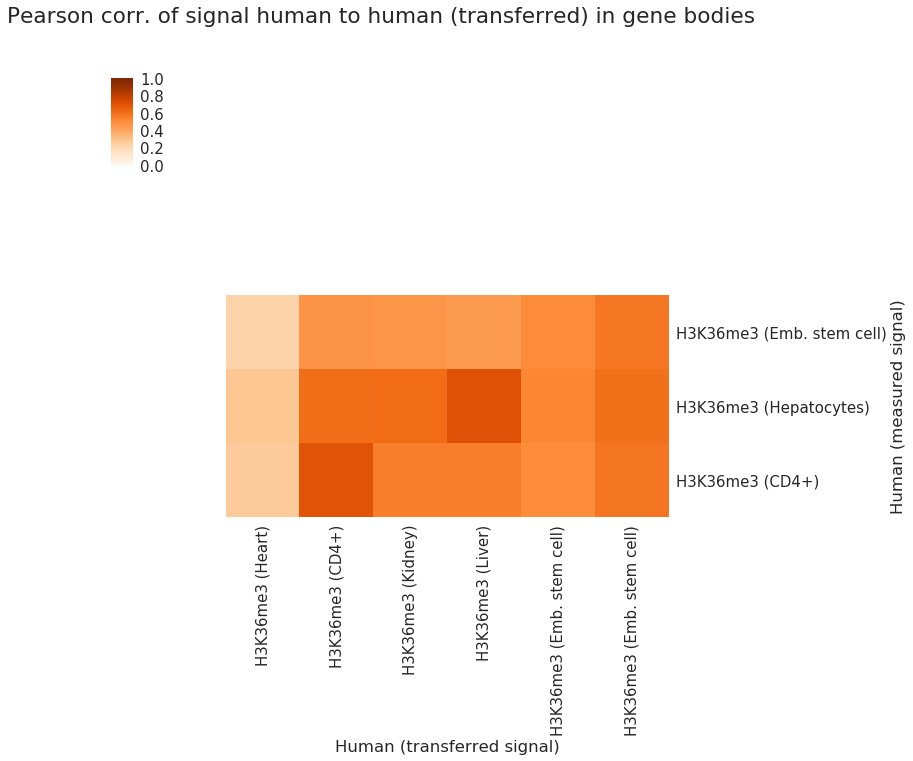

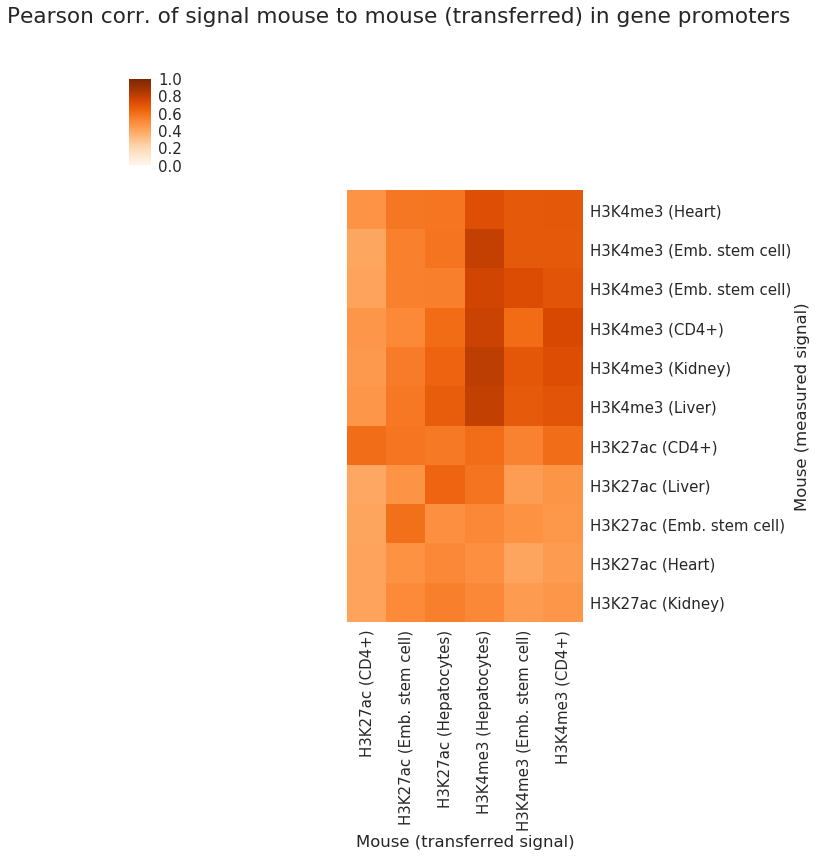

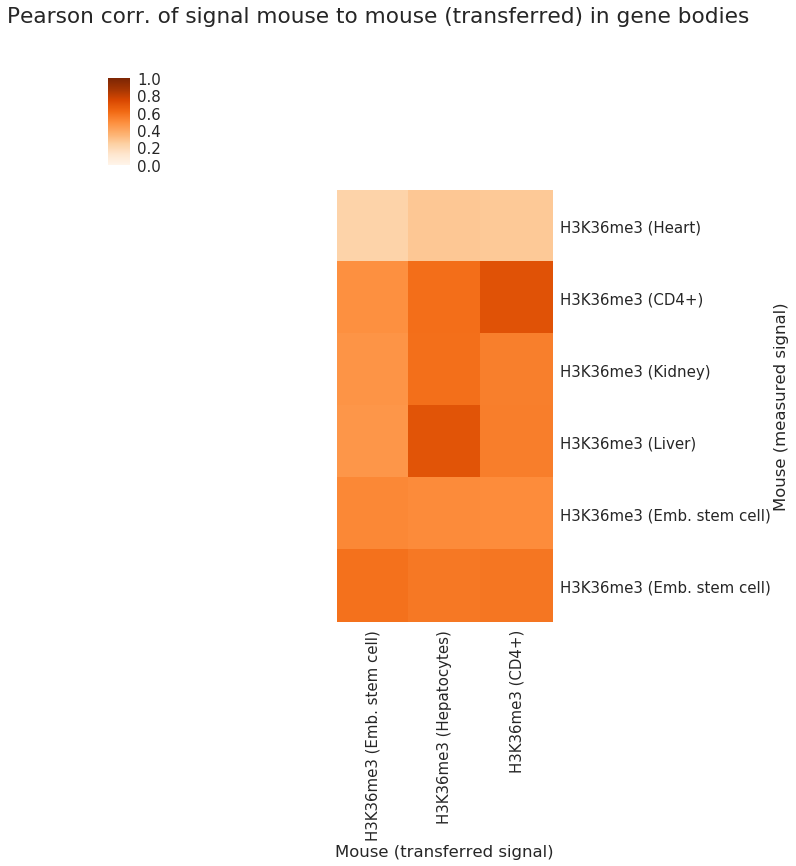

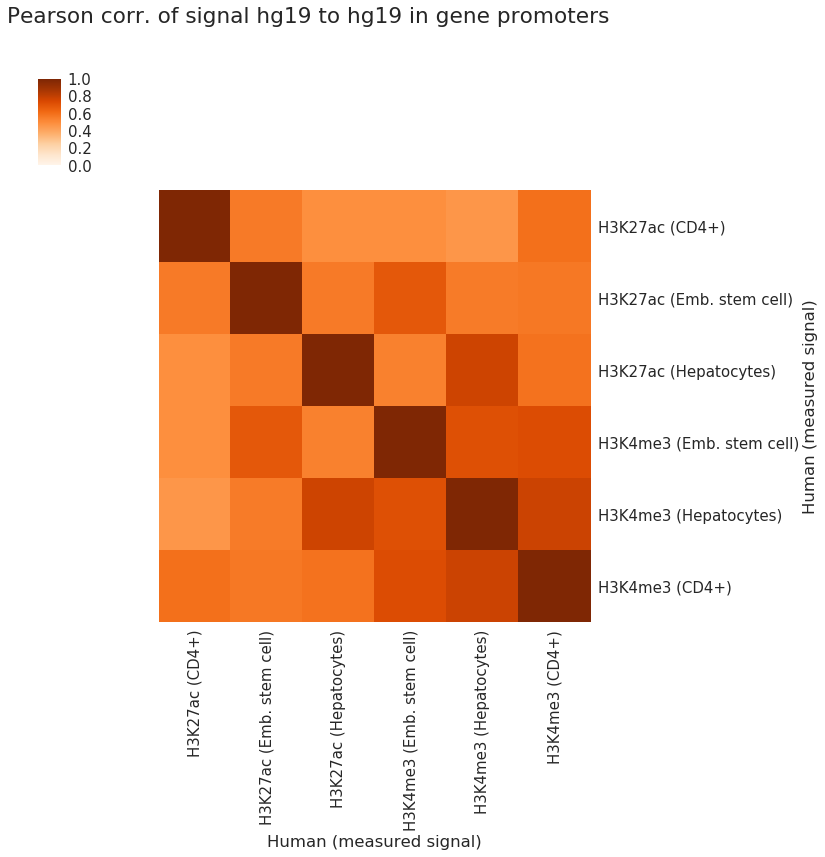

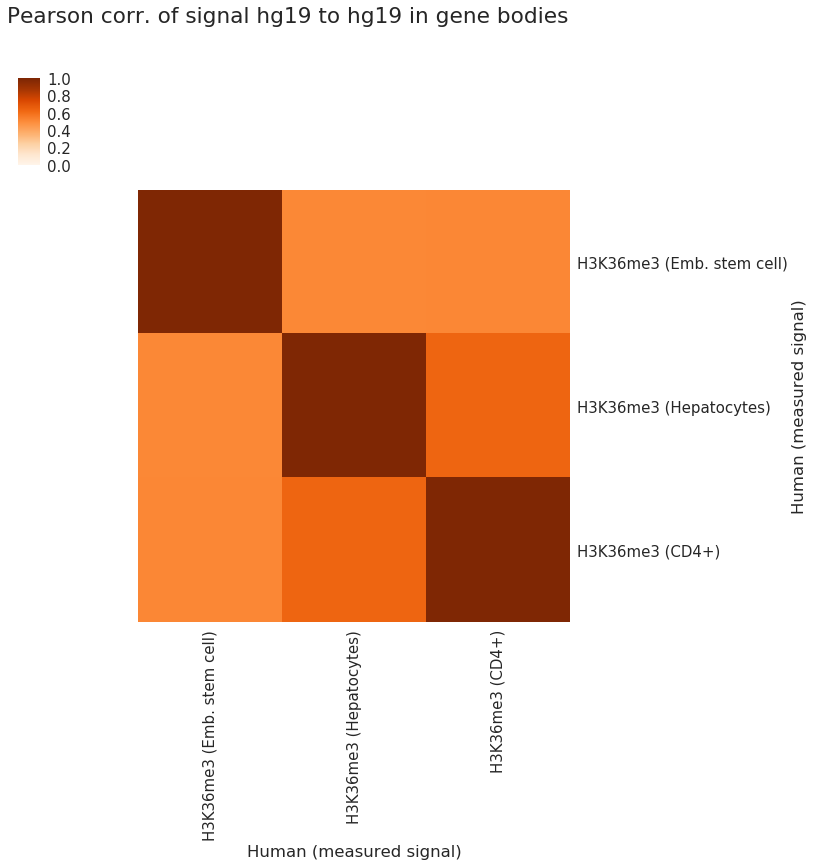

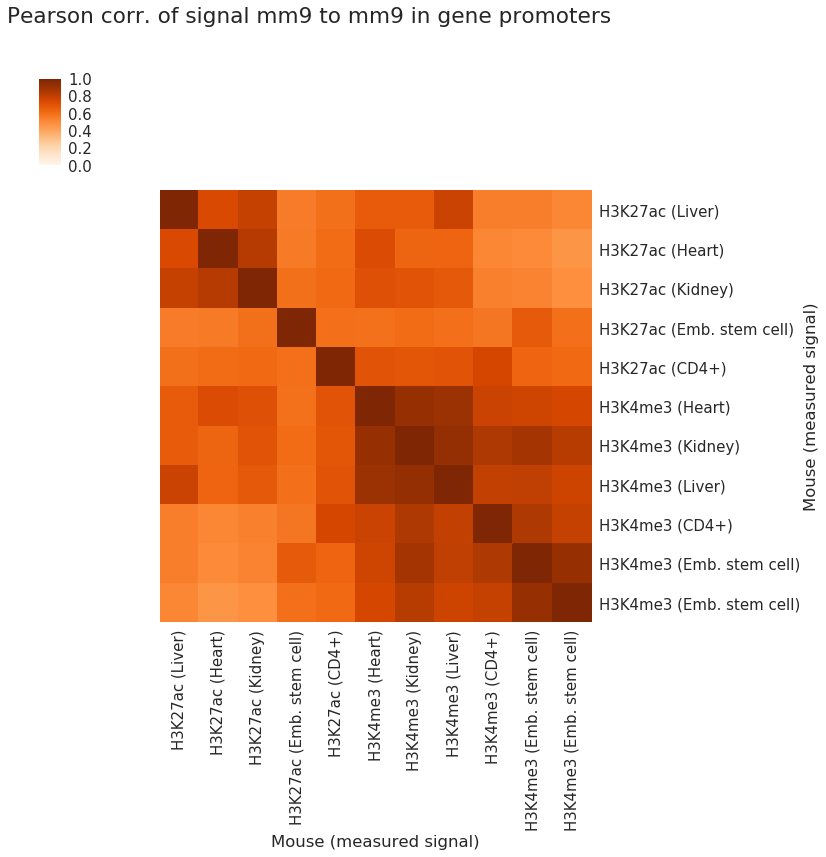

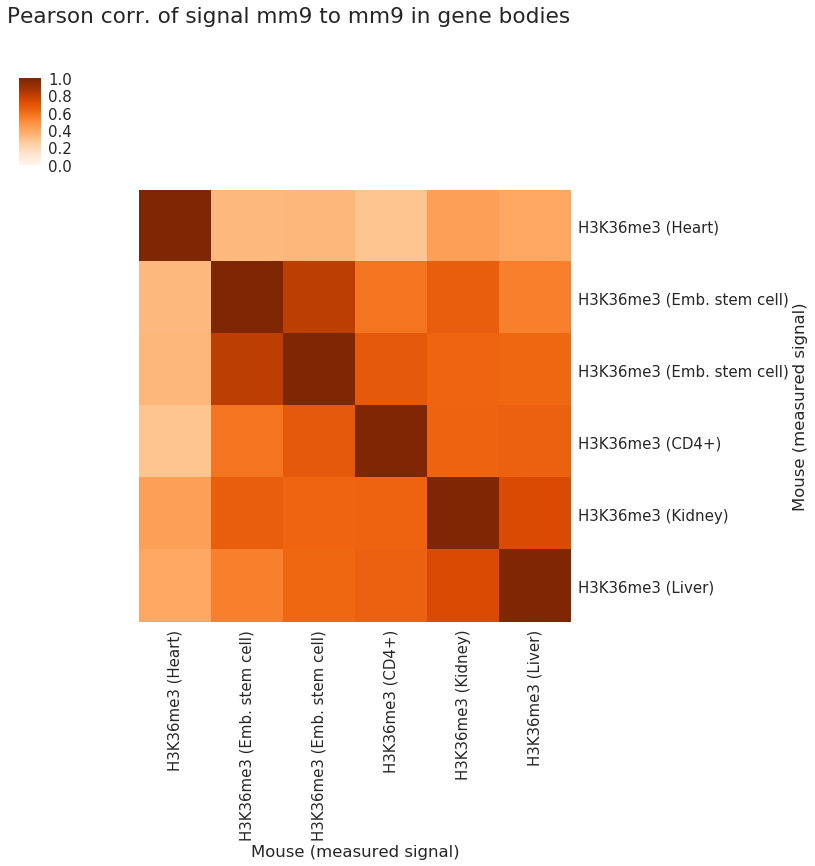

In [14]:
%matplotlib inline

import os as os
import matplotlib.pyplot as plt
import fnmatch as fnm
import json as js
import collections as col

import scipy.cluster.hierarchy as hc
import scipy.spatial.distance as dst
import numpy as np
import pandas as pd
import seaborn as sns

date = '20180314'

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

exec_src_corr = True
exec_map_corr = True

save_figures = True

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))

base_path = '/TL/deep/fhgfs/projects/pebert/thesis/projects/cross_species/processing/norm'
src_corr = os.path.join(base_path, 'task_signal_correlation/sub_roi')
map_corr = os.path.join(base_path, 'task_signal_mapping/mapcorr/corr_roi')

outfolder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub/supp'

prom_marks = ['H3K4me3', 'H3K27ac']
body_marks = ['H3K36me3']

# color_map = "YlOrRd"
color_map = 'Oranges'


def load_json(fpath):
    collector = []
    measure = 'pearson'
    with open(fpath, 'r') as dump:
        data = js.load(dump)['correlations']
        for chrom, info in data:
            collector.append(info[measure]['stat'])
    return np.median(collector)


def plot_clustermap(dataset, title, xlab, ylab):
    """
    """
    # fix: H3K27ac ESE14 has been used twice to complete
    # the other ESE14 epigenome; remove that entry here
    # from the correlation heatmaps
    drop_records = []
    for c in dataset.columns:
        if ('EE04' in c) and ('H3K27ac' in c):
            drop_records.append(c)
    if drop_records:
        dataset.drop(drop_records, axis=1, inplace=True)
    drop_records = []
    for i in dataset.index.tolist():
        if ('EE04' in i) and ('H3K27ac' in i):
            drop_records.append(i)
    if drop_records:
        dataset.drop(drop_records, axis=0, inplace=True)
    # end of fix
    
    new_cols = []
    for c in dataset.columns:
        mark, tissue, _ = c.split('_')
        if tissue in ['H1hESC', 'ESE14']:
            tissue = 'esc'
        new_cols.append('..'.join([mark, tissue]))
    dataset.columns = new_cols
    
    tissue_lut = {'H1hesc': 'Emb. stem cell', 'Ese14': 'Emb. stem cell',
                  'Ncd4': 'CD4+', 'Hepa': 'Hepatocytes', 'Esc': 'Emb. stem cell'}
    
    labels = []
    for i in dataset.index:
        mark, tissue, _ = i.split('_')
        tissue = tissue_lut.get(tissue.capitalize(), tissue.capitalize())
        labels.append('{} ({})'.format(mark, tissue))
    dataset.index = labels
    labels = []
    for c in dataset.columns:
        mark, tissue = c.split('..')
        tissue = tissue_lut.get(tissue.capitalize(), tissue.capitalize())
        labels.append('{} ({})'.format(mark, tissue))
    dataset.columns = labels
    
    t_data = dataset.transpose()
    t_data = t_data.drop_duplicates(keep='first')
    dataset = t_data.transpose()
    
    if dataset.shape[0] == dataset.shape[1]:
        dist_data = dst.squareform(1 - dataset.values)
        link = hc.linkage(dist_data, method='average', metric='euclidean')
        cm = sns.clustermap(dataset, vmin=0, vmax=1, cmap=color_map, center=0.5, annot=False,
                            row_cluster=True, col_cluster=True, row_linkage=link, col_linkage=link,
                            square=True)
        hm_ax = cm.ax_heatmap
        if dataset.shape == (3, 3):
            yticks = hm_ax.get_ymajorticklabels()
            for item in yticks:
                item.set_rotation(0)
        
            xticks = hm_ax.get_xmajorticklabels()
            for item in xticks:
                item.set_rotation(90)
    else:
        cm = sns.clustermap(dataset, vmin=0, vmax=1, cmap=color_map, center=0.5, annot=False,
                            row_cluster=True, col_cluster=True, method='average', metric='euclidean',
                            square=True)
        hm_ax = cm.ax_heatmap
        if dataset.shape == (3, 6):
            yticks = hm_ax.get_ymajorticklabels()
            for item in yticks:
                item.set_rotation(0)
        elif dataset.shape == (6, 3):
            xticks = hm_ax.get_xmajorticklabels()
            for item in xticks:
                item.set_rotation(90)
        else:
            pass
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    hm_ax.set_xlabel(xlab)
    hm_ax.set_ylabel(ylab)
    fig = cm.fig
    exart = [fig.suptitle(title)]
    
    return cm, exart


def run_map_corr():
    if not exec_map_corr:
        return False
    corr_files = os.listdir(map_corr)
    for assm in ['hg19', 'mm9']:
        for region, regname in zip(['reg5p', 'body'], ['promoters', 'bodies']):
            datafiles = fnm.filter(corr_files, '*_{}_*_vs_*{}.json'.format(assm, region))
            rows = col.defaultdict(list)
            for df in datafiles:
                comp = df.split('.')[0].split('_')
                l1 = '_'.join([comp[4], comp[3], comp[1]])
                l2 = '_'.join([comp[9], comp[8], comp[6]])
                if region == 'reg5p':
                    if not (comp[4] in prom_marks and comp[9] in prom_marks):
                        continue
                if region == 'body':
                    if not (comp[4] in body_marks and comp[9] in body_marks):
                        continue
                stat = load_json(os.path.join(map_corr, df))
                rows[l1].append((l2, stat))
            prep = []
            for label, row in rows.items():
                df = pd.DataFrame([[x[1] for x in row]], dtype=np.float32,
                                   columns=[x[0] for x in row], index=[label])
                prep.append(df)
            df = pd.concat(prep, axis=0, ignore_index=False)
            df.sort_index(axis=0, inplace=True)
            other = 'mm9' if assm == 'hg19' else 'hg19'
            spec_a = plot_colors['mapping'][assm]['species']
            spec_b = plot_colors['mapping'][other]['species']
            title = 'Pearson corr. of signal {} to {} (transferred) in gene {}'.format(spec_a, spec_a, regname)
            xlabel = '{} (transferred signal)'.format(spec_a.capitalize())
            ylabel = '{} (measured signal)'.format(spec_a.capitalize())
            cm, exart = plot_clustermap(df, title, xlabel, ylabel)
            
            if save_figures:
                outname = '_'.join([date, 'fig_X_supp_corr', assm, other, region])
                outpath = os.path.join(outfolder, outname + '.svg')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart)
                outpath = os.path.join(outfolder, outname + '.png')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart, dpi=300)
                outpath = os.path.join(outfolder, outname + '.pdf')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart)
    return True


def run_src_corr():
    if not exec_src_corr:
        return False
    corr_files = os.listdir(src_corr)
    for assm in ['hg19', 'mm9']:
        for region, regname in zip(['reg5p', 'body'], ['promoters', 'bodies']):
            datafiles = fnm.filter(corr_files, '*_{}_*_{}.json'.format(assm, region))
            rows = col.defaultdict(list)
            for df in datafiles:
                comp = df.split('.')[0].split('_')
                l1 = '_'.join([comp[4], comp[3], comp[1]])
                l2 = '_'.join([comp[9], comp[8], comp[6]])
                if region == 'reg5p':
                    if not (comp[4] in prom_marks and comp[9] in prom_marks):
                        continue
                if region == 'body':
                    if not (comp[4] in body_marks and comp[9] in body_marks):
                        continue
                stat = load_json(os.path.join(src_corr, df))
                rows[l1].append((l2, stat))
                rows[l2].append((l1, stat))
            prep = []                
            for label, row in rows.items():
                df = pd.DataFrame([[x[1] for x in row]], dtype=np.float32,
                                  columns=[x[0] for x in row], index=[label])
                df = df.loc[:, ~df.columns.duplicated(keep='first')]
                prep.append(df)
            df = pd.concat(prep, axis=0, ignore_index=False)
            df.sort_index(axis=0, inplace=True)
            title = 'Pearson corr. of signal {} to {} in gene {}'.format(assm, assm, regname)
            spec_a = plot_colors['mapping'][assm]['species']
            xlabel = '{} (measured signal)'.format(spec_a.capitalize())
            ylabel = '{} (measured signal)'.format(spec_a.capitalize())
            cm, exart = plot_clustermap(df, title, xlabel, ylabel)
            if save_figures:
                outname = '_'.join([date, 'fig_X_supp_corr', assm, assm, region])
                outpath = os.path.join(outfolder, outname + '.svg')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart)
                outpath = os.path.join(outfolder, outname + '.png')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart, dpi=300)
                outpath = os.path.join(outfolder, outname + '.pdf')
                cm.savefig(outpath, bbox_inches='tight', extra_artists=exart)
    return True


run_map_corr()
run_src_corr()